# Example using G 75-21

In [1]:
%load_ext autoreload
%autoreload 2
    
from RVultra import RVultra, tools
import ultranest
import numpy as np
import pandas as pd

/Users/hugh/miniconda3/envs/radvelnest/lib/python3.9/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


### Initialising the model

This is where key decisions about the model should be stored:

- Prior on semi-amplitude, `kprior` ('log' or 'linear')
- Prior on RV jitter, `jitterprior` ('log', 'linear', or None which follows the `kprior`)
- Prior on eccentricity, `ecc_prior` ('kipping', 'vaneylen', or None, which decides which one to use based on multiplicity)
- Whether to fit curvature, `fit_curv`
- Whether to fit a circular model, `fit_circ`, though this can also be selected specifically for individual planets
- The folder in which to store everything, `outfileloc`

In [2]:
lik=RVultra.Vector_PlanetLikelihood(name="G 75-21", kprior='log', fit_curv=True, fit_circ=False, outfileloc="G75-21_logk")

## Adding stellar parameters:

In [3]:
lik.add_starpars(Ms=0.755, Rs=0.781)

## Adding various RV data:

There's a tonne of extra support for opening RV files in `tools`

In [4]:
sophdat, name = tools.extract_rvfile("G75-21/SophieRVs_TOI4317.csv")
lik.add_data(time=sophdat['time'].values,rvs=sophdat['mnvel'].values,rv_errs=sophdat['errvel'].values,instr="Sophie")
cordat, name = tools.extract_rvfile("G75-21/TIC422914082_COR14_DRS-3-8.rdb")
lik.add_data(time=cordat['time'].values,rvs=cordat['mnvel'].values,rv_errs=cordat['errvel'].values,instr="Coralie")
harpsdat, name = tools.extract_rvfile("G75-21/TIC422914082_HARPS15_DRS-3-0-0.rdb")
lik.add_data(time=harpsdat['time'].values,rvs=harpsdat['mnvel'].values,rv_errs=harpsdat['errvel'].values,instr="HARPS")
harpsndat, name = tools.extract_rvfile("G75-21/TOI-4317_harpn_drs.rdb")
lik.add_data(time=harpsndat['time'].values,rvs=harpsndat['mnvel'].values,rv_errs=harpsndat['errvel'].values,instr="HARPSN")

SOPHIE G75-21/SophieRVs_TOI4317.csv
COR G75-21/TIC422914082_COR14_DRS-3-8.rdb
HARPS G75-21/TIC422914082_HARPS15_DRS-3-0-0.rdb
HARPS-N G75-21/TOI-4317_harpn_drs.rdb


## Adding the planets to the model:

Here, we split transiting and non-transiting planets, as the transit duration can tell us something about the planetary velocity (and therefore eccentricity). 

It is also necessary to specify exactly which parameters to hold fixed (using `fix_params`), and which ones to model (using `model_params`).

For RV planets where we are modelling the period and tcen, we can specify the uncertainties in those parameters which are used as a uniform prior input. 

In [5]:
#A transiting planet where we will fix the period and tc using our knowledge from the transits:
lik.add_transiting_planet(plname='b', per=23.885495, tcen=2459148.11893, Rp_Rs=0.04098, tdur=0.17385, bmu=0.45536, bsigma=0.21804,
                          model_params=['logk'], fix_params=['per','tc'], fit_circ=True)

#An RV-only (i.e. non-transiting planet) where we will model the period and tc, but keep the orbit circular:
lik.add_rv_planet(plname='c', per=34.8, tcen=2460331.3, e_per=0.1*34.8, e_tcen=0.55*34.8,
                  model_params=['per','tc','logk'],fit_circ=True)

### Getting ready to sample

Once the model is ready, we need to initialise it:

In [6]:
lik.init_model()

#### Checking the model parameters using `lik.varpars`

In [7]:
lik.varpars

{'logk_b': ['uniform', -0.15528426645013516, 3.4891064832413314],
 'per_c': ['uniform', 31.319999999999997, 38.279999999999994],
 'tc_c': ['uniform', 2460312.1599999997, 2460350.44],
 'logk_c': ['uniform', -0.15528426645013516, 3.4891064832413314],
 'logjitter_Coralie': ['norm', 2.977133636170986, 0.5],
 'offset_Coralie': ['norm', 76761.342368, 15.80832409145571],
 'logjitter_HARPS': ['norm', 1.3455331720426138, 0.5],
 'offset_HARPS': ['norm', 76739.807222, 5.813102514069161],
 'logjitter_HARPSN': ['norm', -0.05836344733929068, 0.5],
 'offset_HARPSN': ['norm', 76765.9249587909, 5.923608416251665],
 'logjitter_Sophie': ['norm', 2.1972245773362196, 0.5],
 'offset_Sophie': ['norm', 76658.5, 8.481597726843686],
 'polytrend': ['norm', 0.029384513044478155, 0.029400778254429445],
 'polycurv': ['norm', 0.0, 0.02161014404915328]}

## Sampling using Ultranest model

One key parameter here is whether to resume from a previous run (`resume=True`) or not (`resume=overwrite`)

In [8]:
lik.sample(resume=True)

[ultranest] Resuming from 1551 stored points


[ultranest] Explored until L=-2e+02  .40 [-186.0629..-186.0621]*| it/evals=13800/12184867 eff=0.1133% N=400 0    0  0 
[ultranest] Likelihood function evaluations: 12184867
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -215.5 +- 0.2161
[ultranest] Effective samples strategy satisfied (ESS = 4223.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.22, need <0.5)
[ultranest]   logZ error budget: single: 0.25 bs:0.22 tail:0.01 total:0.22 required:<0.50
[ultranest] done iterating.

logZ = -215.613 +- 0.461
  single instance: logZ = -215.613 +- 0.246
  bootstrapped   : logZ = -215.542 +- 0.461
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    logk_b              : -0.16 │▁▁▁▁▁▂▂▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇▇▇▅▄▃▃▂▁▁▁▁  ▁ │2.05      0.95 +- 0.37
   

## Creating plots from Ultranest:

In [9]:
lik.sample_plots()

## Creating plots from the RVs:

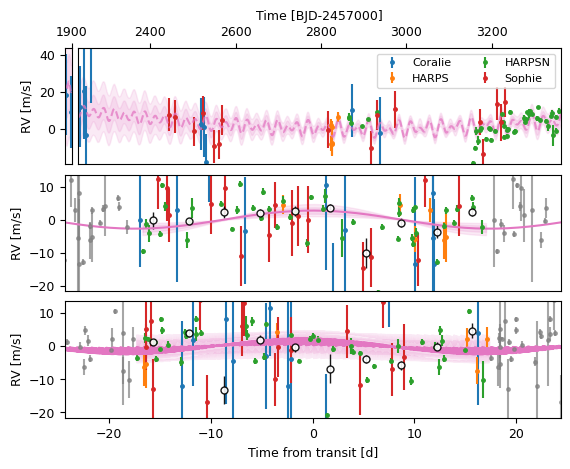

In [10]:
lik.rv_plot(savetype='png')

## Creating tables from the data

In [11]:
model_summary = lik.create_output_dict(fixsampler.results)
model_summary

AttributeError: 'Vector_PlanetLikelihood' object has no attribute 'create_output_dict'

## Comparing to a no-planet model:

In [ ]:
flatlik.outfileloc

In [ ]:
flatvarpars={vpk:lik.varpars[vpk] for vpk in lik.varpars if vpk[:4] in ['poly','jitt','logj','offs']}#Taking only the non-planetary variables
#Copying the parameters from our with-planet model:
flatlik=RVultra.Vector_FlatLikelihood(name="G 75-21", data=lik.data, varnames=list(flatvarpars.keys()), 
                              jitprior=lik.kprior, fit_curv=lik.fit_curv)
flatsampler = ultranest.ReactiveNestedSampler(list(flatvarpars.keys()), flatlik, RVultra.VectorPriorTransform(flatvarpars), 
                                            log_dir=flatlik.outfileloc,
                                            resume=True, vectorized=True)
flatresult = flatsampler.run()

In [ ]:
flat_summary = flatlik.summarise_results(flatresult)
flat_summary

## Model comparison between them:

In this case, a large (>5) positive Bayesian log Evidence shows that the planet model is favoured:

In [ ]:
print("Difference in Bayesian log Evidence is {:.2f}".format(model_summary.loc['logEvidence','mean']-flat_summary.loc['logEvidence','mean']))
print("Planet model is {:.2f} times more probable.".format(np.exp(model_summary.loc['logEvidence','mean']-flat_summary.loc['logEvidence','mean'])))